# Algorytm najbliższego sąsiada

Algorytm K-najbliższych sąsiadów (KNN) to prosty algorytm służący do klasyfikowania punktów danych na podstawie ich bliskości względem innych punktów danych. W przypadku nowego, niesklasyfikowanego punktu danych algorytm KNN sprawdza "k" najbliższych sąsiadów i klasyfikuje go do grupy w której jest więcej sąsiadów.

Wizualizacja algorytmu [tutaj](https://www.youtube.com/watch?v=gs9E7E0qOIc).

## Import bibliotek i wczytanie danych

Wykorzystany zostanie zbiór danych [breast_cancer.csv](data/breast_cancer.csv), pobrany ze strony [kaggle.com](https://www.kaggle.com/datasets/khansaafreen/breastdataset). 

Zadaniem modelu będzie klasyfikacja nowotworów piersi złośliwych (M) i łagodnych (B).

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, log_loss, roc_curve
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data/breast_cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Przygotowanie danych

Na początku usuwam kolumnę *id*, ponieważ nie jest ona cechą niezależną, oraz kolumnę *Unnamed: 32*, która zawiera puste wartości.

Następnie zamieniam wartości w kolumnie *diagnosis* na 0 dla nowotworu łagodnego i 1 dla złośliwego.

Na koniec upewniam się, że zbiór nie zawiera pustych wartości.

In [2]:
df.drop(columns=["id", "Unnamed: 32"], inplace=True)
df["diagnosis"] = df["diagnosis"].map(lambda x: 1 if x == "M" else 0)
df.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

### Usunięcie kolumn nieskorelowanych

W celu poprawy wyniku klasyfikacji usuwam kolumny o współczynniku korelacji zbliżonym do 0.

In [3]:
df.corr()['diagnosis'].sort_values(ascending=False)

diagnosis                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

In [4]:
df.drop(columns=["fractal_dimension_se", "symmetry_se", "texture_se", "fractal_dimension_mean", "smoothness_se"], inplace=True)

Dane są teraz gotowe do uczenia. Pozostaje tylko podział na zbiór cech niezależnych i zależnych. 

In [5]:
x = df.drop(columns=["diagnosis"])
y = df["diagnosis"]

## Uczenie modelu

Dane w zbiorze nie są tego samego rzędu wielkości, dlatego dla polepszenia jakości klasyfikacji skaluje je za pomocą **StandardScaler()**. Skalowanie usuwa dominację cech o większych wartościach.

Do uczenia modelu wykorzystuję klasę **KNeighborsClassifier**. Aby znaleźć jak najlepszą liczbę *k*, korzystam z GridSearchCV.

GridSearchCV testuje wszystkie możliwe kombinacje parametrów zdefiniowanych w **param_grid**. Dodatkowo wykorzystuje on walidacje krzyżową.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
param_grid = {
    "kNN__n_neighbors": [3, 5, 7, 9]
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('kNN', KNeighborsClassifier())
])
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy")

grid.fit(x_train, y_train)
print(f"Dokładność wszystkich modeli: {grid.cv_results_["mean_test_score"]}")

model = grid.best_estimator_
print(f"Wybrana liczba k: {model.get_params()["kNN__n_neighbors"]}")

Dokładność wszystkich modeli: [0.96263736 0.96703297 0.96263736 0.96483516]
Wybrana liczba k: 5


## Mierzenie skuteczności modelu

Graficznym sposobem przedstawienia poprawności klasyfikacji jest wygenerowanie **macierzy pomyłek (confusion matrix)**.

Sprawdza przewidywania modelu z rzeczywistymi etykietami, przedstawiając liczbę prawidłowych i błędnych klasyfikacji.

Nasza macierz składa się z 4 pól:

**True Positives (TP)**: liczba poprawnie sklasyfikowanych pozytywnych przypadków.

**True Negatives (TN)**: liczba poprawnie sklasyfikowanych negatywnych przypadków.

**False Positives (FP)**: liczba przypadków, które zostały błędnie sklasyfikowane jako pozytywne.

**False Negatives (FN)**: liczba przypadków, które zostały błędnie sklasyfikowane jako negatywne.

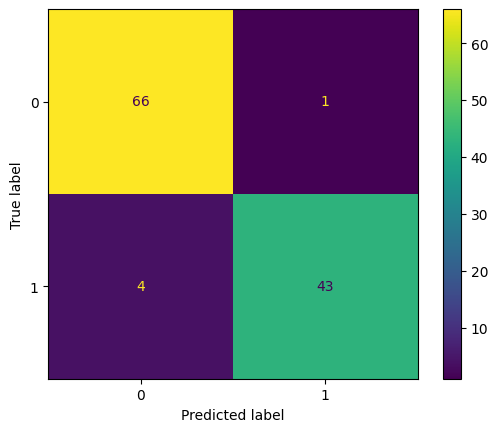

In [7]:
y_pred = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()

Głównymi metrykami wykorzystywanymi do analizy modelu są:

**Precyzja (precision)**: odsetek poprawnych przewidywań pozytywnej klasy spośród wszystkich przypadków oznaczonych przez model jako pozytywne.

$$ Precyzja = \frac{TP}{TP + FP} $$

**Czułość (recall)**: odsetek rzeczywistych przypadków pozytywnych, które model poprawnie wykrył spośród wszystkich rzeczywistych pozytywów.

$$ Czulosc = \frac{TP}{TP + FN} $$

**Wskaźnik F1**: średnia harmoniczna precyzji i czułości, łącząca obie miary w jedną wartość.
$$ F1 = \frac{2*Precyzja*Czulosc}{Precyzja + Czulosc} $$

**Dokładność (accuracy)**: odsetek poprawnie sklasyfikowanych próbek (zarówno pozytywnych, jak i negatywnych) spośród wszystkich próbek.
$$ Dokladnosc = \frac{TP + TN}{Wszystkie} $$

**Support**: zlicza ile przypadków wystąpiło w zbiorze.

**Macro avg**: średnia arytmetyczna metryk dla każdej klasy, traktując je równoważnie.

**Weighted avg**: średnia ważona według liczby próbek (supportu) w każdej klasie.


In [8]:
print(classification_report(y_test, y_pred, target_names=["Łagodny nowotwór", "Złośliwy nowotwór"]))

                   precision    recall  f1-score   support

 Łagodny nowotwór       0.94      0.99      0.96        67
Złośliwy nowotwór       0.98      0.91      0.95        47

         accuracy                           0.96       114
        macro avg       0.96      0.95      0.95       114
     weighted avg       0.96      0.96      0.96       114



Dodatkowymi metrykami wykorzystywanymi do oceny klasyfikacji są **ROC, AUC** i **log_loss**.

**Krzywa ROC** - wykres służący do oceny jakości modeli klasyfikacji binarnej, który pokazuje, jak dobrze model rozróżnia dwie klasy przy różnych progach decyzyjnych (thresholds). Krzywa rysowana jest przez obliczenie współczynników **TPR** (recall) i **FPR** (specificity).

$$ TPR = \frac{TP}{TP + FN} $$

$$ FPR = \frac{FP}{TN + FP} $$


**Obszar pod krzywą ROC (AUC)** - prawdopodobieństwo, że model, jeśli otrzyma losowo wybrany przykład pozytywny i negatywny, sklasyfikuje przykład pozytywny wyżej niż negatywny.

| AUC     | Interpretacja |
| ------- | ------------- |
| 0.5     | Model losowy  |
| 0.6–0.7 | Słaby         |
| 0.7–0.8 | Dobry         |
| 0.8–0.9 | Bardzo dobry  |
| 0.9–1.0 | Doskonały     |


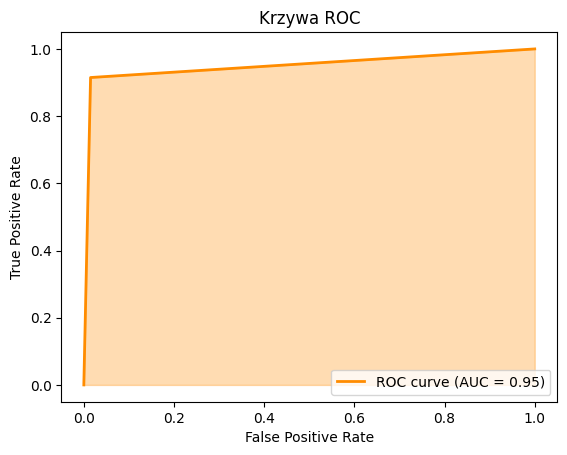

In [9]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.fill_between(fpr, tpr, color='darkorange', alpha=0.3)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc='lower right')
plt.show()


**Log loss** - oblicza, jak bardzo rozbieżne są przewidywane prawdopodobieństwa od prawdziwych etykiet w zbiorze danych.

Dla klasyfikacji binarnej (dwie klasy: 0 i 1), wzór na log loss wygląda następująco:

$$
\text{Log Loss} = - \frac{1}{n} \sum_{i=1}^{n} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]
$$
Gdzie:
- $ n $ to liczba próbek w zbiorze danych
- $ y_i $ to rzeczywista etykieta klasy (0 lub 1) dla próbki,
- $ p_i $ to przewidywane prawdopodobieństwo, że próbka należy do klasy pozytywnej (1).


In [10]:
print(f"Log loss: {log_loss(y_test, y_pred)}")

Log loss: 1.5808619907507522
